In [1]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 22.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [2]:
import keras
from keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import random
import torch
import copy
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, accuracy_score
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import scipy.io
from scipy.io import savemat
import wfdb
random.seed(42)

,symbol,Counts,Patient Number
0,+,1,100
1,A,33,100
2,N,2239,100
3,V,1,100
0,+,1,101
...,...,...,...
0,+,3,234
1,J,50,234
2,N,2700,234
3,V,3,234


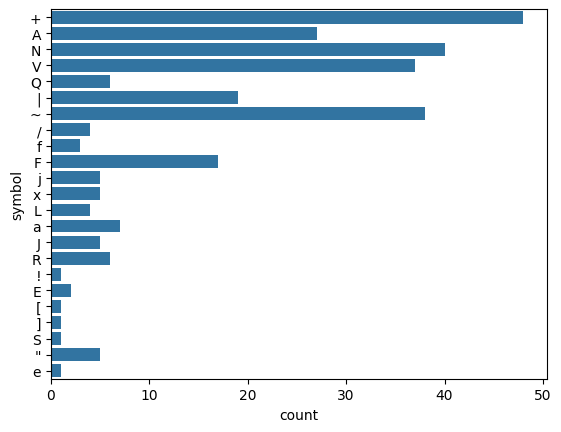

In [3]:
data = '/content/drive/MyDrive/MLSA BUP/MIT-BIH Dataset/'
patients = ['100','101','102','103','104','105','106','107',
           '108','109','111','112','113','114','115','116',
           '117','118','119','121','122','123','124','200',
           '201','202','203','205','207','208','209','210',
           '212','213','214','215','217','219','220','221',
           '222','223','228','230','231','232','233','234']
dataframe = pd.DataFrame()
for pts in patients:
    file = data + pts
    annotation = wfdb.rdann(file, 'atr')
    sym = annotation.symbol
    values, counts = np.unique(sym, return_counts=True)
    df_sub = pd.DataFrame({'symbol': values, 'Counts': counts, 'Patient Number': [pts]*len(counts)})
    dataframe = pd.concat([dataframe, df_sub], axis=0)
ax = sns.countplot(dataframe.symbol)
dataframe

In [4]:
nonbeat = ['[','!',']','x','(',')','p','t','u','`',
           '\'','^','|','~','+','s','T','*','D','=','"','@','Q','?']
abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S']
normal = ['N']
dataframe['category'] = -1
dataframe.loc[dataframe.symbol == 'N', 'category'] = 0
dataframe.loc[dataframe.symbol.isin(abnormal), 'category'] = 1
print(dataframe.groupby('category').Counts.sum())
dataframe = dataframe.loc[~((dataframe['category']==-1))]
print(dataframe.groupby('category').Counts.sum())

category
-1     3186
 0    75052
 1    34409
Name: Counts, dtype: int64
category
0    75052
1    34409
Name: Counts, dtype: int64


In [5]:
def load_ecg(file):
    record = wfdb.rdrecord(file)
    annotation = wfdb.rdann(file, 'atr')
    p_signal = record.p_signal
    atr_sym = annotation.symbol
    atr_sample = annotation.sample
    return p_signal, atr_sym, atr_sample

In [6]:
def build_XY(p_signal, df_ann, num_cols, normal):
    num_rows = len(df_ann)
    X = np.zeros((num_rows, num_cols))
    Y = np.zeros((num_rows, 1))
    sym = []
    max_row = 0
    for atr_sample, atr_sym in zip(df_ann.atr_sample.values, df_ann.atr_sym.values):
        left = max([0, (atr_sample - num_sec*fs)])
        right = min([len(p_signal), (atr_sample + num_sec*fs)])
        x = p_signal[left:right]
        if len(x) == num_cols:
            X[max_row, :] = x
            Y[max_row, :] = int(atr_sym in normal)
            sym.append(atr_sym)
            max_row += 1
    X = X[:max_row, :]
    Y = Y[:max_row, :]
    return X, Y, sym

In [7]:
p_signal, atr_sym, atr_sample = load_ecg(data + '100')
df_ann = pd.DataFrame({'atr_sym': atr_sym, 'atr_sample': atr_sample})
num_sec = 1
fs = 360
num_cols = 2*num_sec*fs
X, Y, sym = build_XY(p_signal[:, 0], df_ann, num_cols, ['N'])
print(X.shape, Y.shape)

(2270, 720) (2270, 1)


In [8]:
def make_dataset(pts, num_sec, fs, abnormal):
    num_cols = 2*num_sec * fs
    X_all = np.zeros((1, num_cols))
    Y_all = np.zeros((1, 1))
    sym_all = []
    max_rows = []
    for pt in pts:
        file = data + pt
        p_signal, atr_sym, atr_sample = load_ecg(file)
        p_signal = p_signal[:, 0]
        df_ann = pd.DataFrame({'atr_sym': atr_sym, 'atr_sample': atr_sample})
        df_ann = df_ann.loc[df_ann.atr_sym.isin(abnormal)]
        X, Y, sym = build_XY(p_signal, df_ann, num_cols, abnormal)
        sym_all = sym_all + sym
        max_rows.append(X.shape[0])
        X_all = np.append(X_all, X, axis=0)
        Y_all = np.append(Y_all, Y, axis=0)
    X_all = X_all[1:, :]
    Y_all = Y_all[1:, :]
    return X_all, Y_all, sym_all

num_sec = 1
fs = 360
X_abnormal, Y_abnormal, sym_abnormal = make_dataset(patients, num_sec, fs, abnormal)

In [9]:
data = '/content/drive/MyDrive/MLSA BUP/mit-bih-normal-sinus-rhythm-database-1.0.0/'
patients = ["16265", "16272"]
def make_dataset(pts, num_sec, fs, normal):
    num_cols = 2*num_sec * fs
    X_all = np.zeros((1, num_cols))
    Y_all = np.zeros((1, 1))
    sym_all = []
    max_rows = []
    for pt in pts:
        file = data + pt
        p_signal, atr_sym, atr_sample = load_ecg(file)
        p_signal = p_signal[:, 0]
        df_ann = pd.DataFrame({'atr_sym': atr_sym, 'atr_sample': atr_sample})
        df_ann = df_ann.loc[df_ann.atr_sym.isin(normal)]
        X, Y, sym = build_XY(p_signal, df_ann, num_cols, normal)
        sym_all = sym_all + sym
        max_rows.append(X.shape[0])
        X_all = np.append(X_all, X, axis=0)
        Y_all = np.append(Y_all, Y, axis=0)
    X_all = X_all[1:, :]
    Y_all = Y_all[1:, :]
    return X_all, Y_all, sym_all

num_sec = 1
fs = 360
X_normal, Y_normal, sym_normal = make_dataset(patients, num_sec, fs, normal)

In [10]:
X_normal = X_normal[0:34376, :]
Y_normal = np.zeros((34376, 1))

In [11]:
X = np.append(X_normal, X_abnormal, axis=0)
Y = np.append(Y_normal, Y_abnormal, axis=0)
X = X[:, 0:140]
raw_data = np.append(X, Y, axis=1)
raw_data = pd.DataFrame(raw_data)
labels = raw_data.iloc[:, -1]
labels = labels.values
data = raw_data.iloc[:, 0:-1]
data = data.values

In [12]:
from sklearn.preprocessing import MinMaxScaler
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21)
scaler = MinMaxScaler()
scaler.fit(train_data)
test_data = scaler.transform(test_data)
train_data = scaler.transform(train_data)
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)
normal_train_data = train_data[~train_labels]
normal_test_data = test_data[~test_labels]
anomalous_train_data = train_data[train_labels]
anomalous_test_data = test_data[test_labels]
val_df, test_df = train_test_split(
    test_data, test_size=0.2, random_state=42)
test_labels = ~test_labels

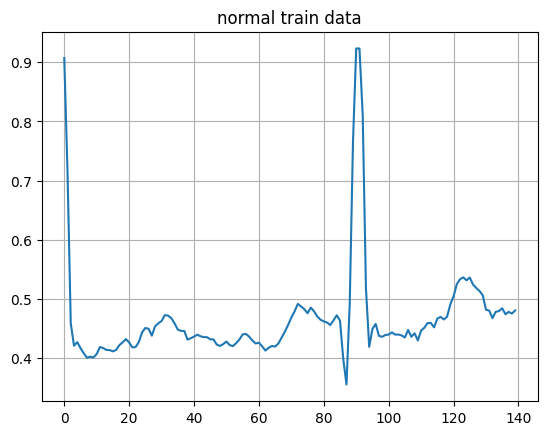

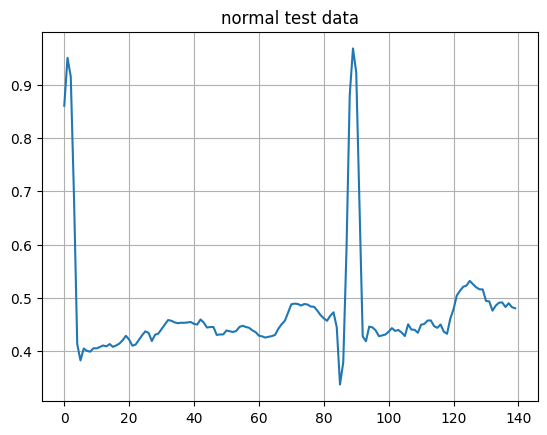

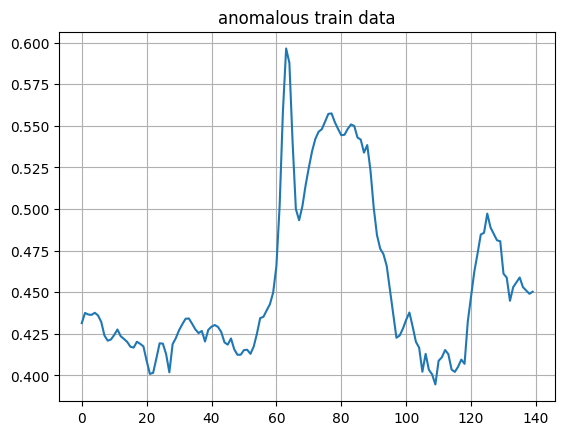

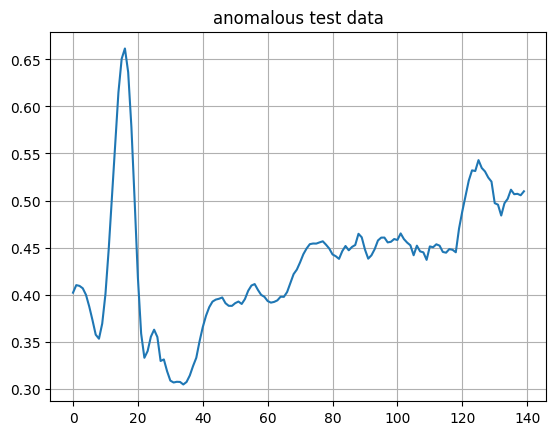

In [13]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("normal train data")
plt.show()
plt.grid()
plt.plot(np.arange(140), normal_test_data[543])
plt.title("normal test data")
plt.show()
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("anomalous train data")
plt.show()
plt.grid()
plt.plot(np.arange(140), anomalous_test_data[0])
plt.title("anomalous test data")
plt.show()

Epoch 1/500
216/216 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 0.0411 - val_loss: 0.0345
Epoch 2/500
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0341 - val_loss: 0.0356
Epoch 3/500
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0333 - val_loss: 0.0329
Epoch 4/500
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0322 - val_loss: 0.0317
Epoch 5/500
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0311 - val_loss: 0.0312
Epoch 6/500
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0304 - val_loss: 0.0300
Epoch 7/500
216/216 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0295 - val_loss: 0.0295
Epoch 8/500
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0290 - val_loss: 0.0285
Epoch 9/500
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0282 - val_loss: 0.0286
Epoch 10/500
216/216 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0277 - val_loss: 0.0294
Epoch 11/500
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0275 - val_loss: 0.0277
Epoch 12/500
216/216 ━━━━━━━━━━━━━━━━━━

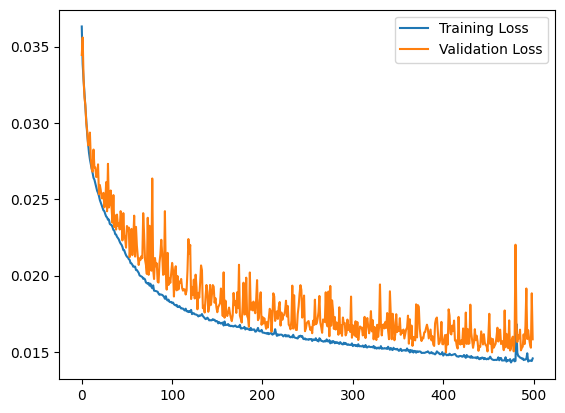

In [15]:
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(128, activation="relu"),
            layers.Dense(64, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(16, activation="relu"),
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(16, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(64, activation="relu"),
            layers.Dense(128, activation="relu"),
            layers.Dense(140, activation="sigmoid")
        ])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AnomalyDetector()
autoencoder.compile("adam", loss="mean_absolute_error")
history = autoencoder.fit(normal_train_data, normal_train_data,
                         epochs=500, batch_size=128,
                         validation_data=(normal_test_data, normal_test_data),
                         shuffle=True)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

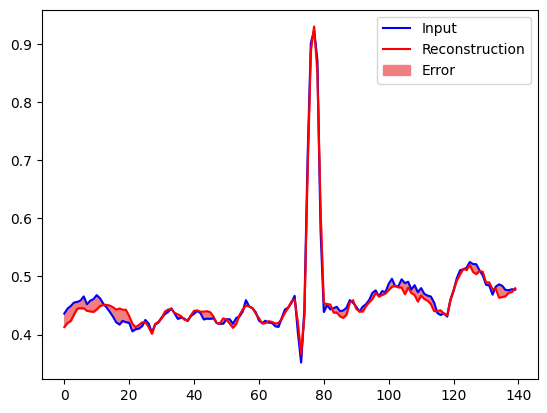

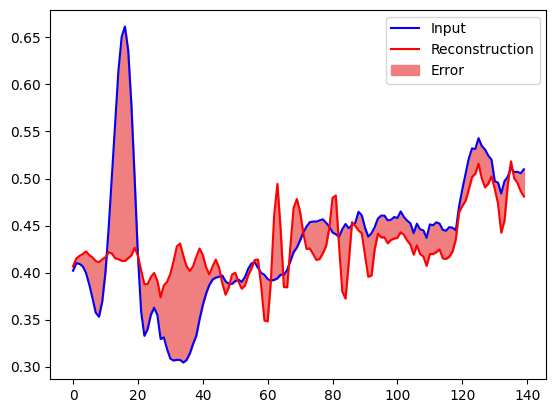

In [16]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()
plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()
plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

861/861 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


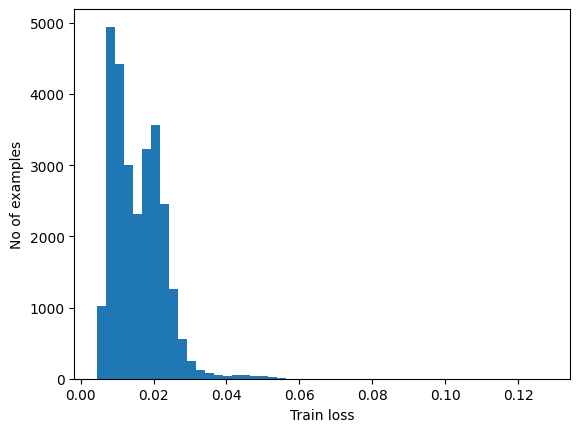

Threshold:  0.022894923625036392
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


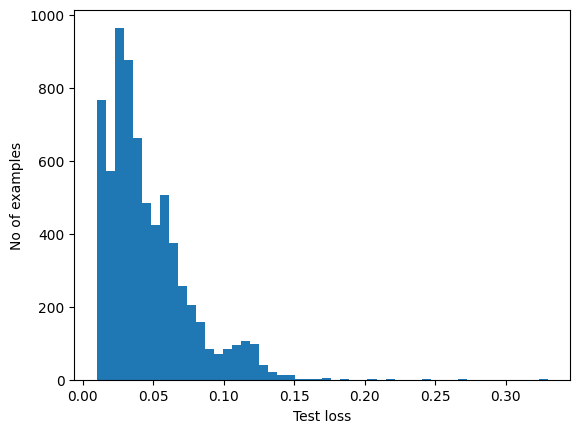

Accuracy = 0.8315031634062977
Precision = 0.8153760600583901
Recall = 0.8557046979865772


In [17]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)
plt.hist(train_loss[None, :], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)
plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)
def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


<ipython-input-18-a0835f4cb516>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_loss, bins=50, kde=True)


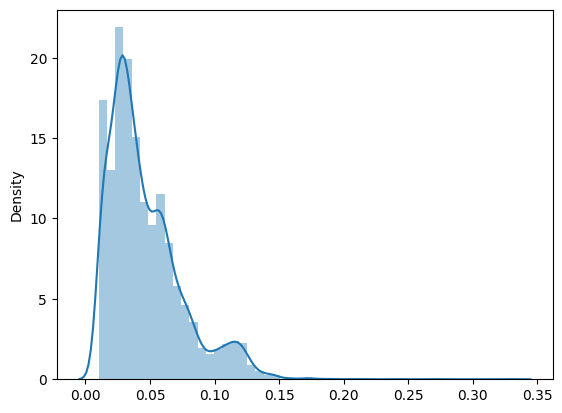

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Correct normal predictions: 5865/6854
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Correct anomaly predictions: 5569/6897


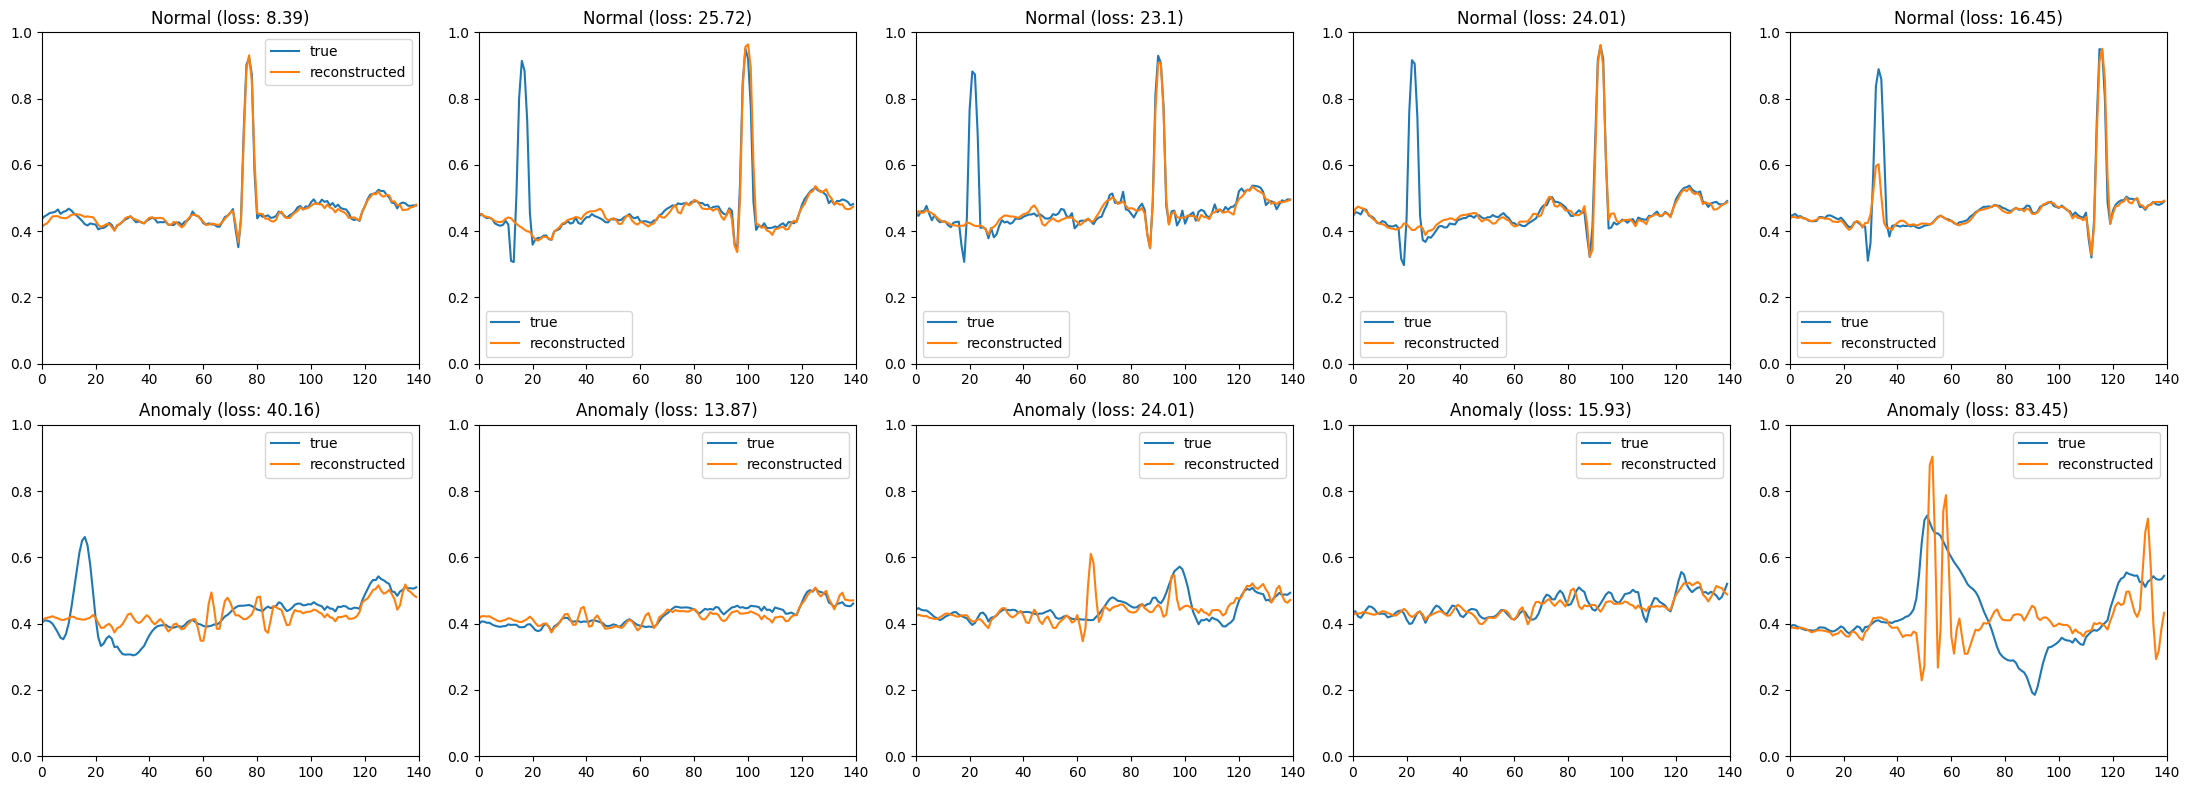

In [18]:
reconstructions = autoencoder.predict(anomalous_test_data)
train_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)
sns.distplot(train_loss, bins=50, kde=True)
plt.show()
reconstructions = autoencoder.predict(normal_test_data)
pred_loss = tf.keras.losses.mae(reconstructions, normal_test_data)
pred_loss = pred_loss.numpy()
correct = sum(l <= threshold for l in pred_loss)
print(f'Correct normal predictions: {correct}/{len(normal_test_data)}')
reconstructions = autoencoder.predict(anomalous_test_data)
train_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)
train_loss = train_loss.numpy()
correct = sum(l > threshold for l in train_loss)
print(f'Correct anomaly predictions: {correct}/{len(anomalous_test_data)}')
def plot_prediction_normal(i, data, model, title, ax):
    encoded_data = autoencoder.encoder(data).numpy()
    decoded_data = autoencoder.decoder(encoded_data).numpy()
    ax.axis([0, 140, 0, 1])
    ax.plot(data[i], label='true')
    ax.plot(decoded_data[i], label='reconstructed')
    ax.set_title(f'{title} (loss: {np.around(1000*pred_loss[i], 2)})')
    ax.legend()
def plot_prediction_anomaly(i, data, model, title, ax):
    encoded_data = autoencoder.encoder(data).numpy()
    decoded_data = autoencoder.decoder(encoded_data).numpy()
    ax.axis([0, 140, 0, 1])
    ax.plot(data[i], label='true')
    ax.plot(decoded_data[i], label='reconstructed')
    ax.set_title(f'{title} (loss: {np.around(1000*train_loss[i], 2)})')
    ax.legend()
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(22, 8))
for i in range(5):
    plot_prediction_normal(i, normal_test_data, autoencoder, title='Normal', ax=axs[0, i])
for i in range(5):
    plot_prediction_anomaly(i, anomalous_test_data, autoencoder, title='Anomaly', ax=axs[1, i])
fig.tight_layout()
plt.show()